# Import Packages

In [29]:
# Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

# NLP Packages
import nltk 
from nltk.corpus import stopwords
from textblob import TextBlob 
from textblob import Word
import re
import string

# Sklearn Packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from sklearn import metrics
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist
from nltk.corpus import stopwords

# Pandas Settings
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 100)

import pickle

# Solve warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# DataFrame Size Reduction

In [12]:
# Import csv file
df = pd.read_csv('../csv/Hotel_Reviews.csv')

In [13]:
# Checking the shape of the dataframe
df.shape

(515738, 17)

In [14]:
# Checking the name of columns
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [15]:
# Selecting only the columns that I will use
features = ['Hotel_Name', 'Negative_Review','Positive_Review', 'Reviewer_Score']
df = df[features]

In [16]:
# Putting reviews together
df['Reviews'] = df['Negative_Review'] + df['Positive_Review']

In [17]:
# Reducing the size of the dataframe to 30%
df = df.sample(frac=0.3, random_state=1)

In [18]:
# Checking if it worked
df.shape

(154721, 5)

In [19]:
# Checking null values
df.isna().sum()

Hotel_Name         0
Negative_Review    0
Positive_Review    0
Reviewer_Score     0
Reviews            0
dtype: int64

In [20]:
# Checking how many hotels in this dataset
len(df.Hotel_Name.unique())

1492

In [21]:
# Checking the hotel with the highest number of reviews
df.pivot_table(index=['Hotel_Name'], aggfunc='size').nlargest()

Hotel_Name
Britannia International Hotel Canary Wharf           1430
Strand Palace Hotel                                  1342
Park Plaza Westminster Bridge London                 1273
Copthorne Tara Hotel London Kensington               1100
DoubleTree by Hilton Hotel London Tower of London     963
dtype: int64

# Data Cleaning

In [22]:
# This function lowercase all the review words, removes punctuation and numbers
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

round1 = lambda x: clean_text_round1(x)

In [23]:
# Applying clean_text_round1 function
df['Reviews_Clean'] = pd.DataFrame(df.Reviews.apply(round1))

In [24]:
# Create function that turns the Reviewer Score into a classification target with 3 values
df['Score'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 5 else 1 if x >= 5 and x < 7 else 2)

In [25]:
# Checking if function worked
df[['Reviewer_Score', 'Score']].head(5)

,Reviewer_Score,Score
356054,10.0,2
395957,10.0,2
468352,6.7,1
281462,9.6,2
498978,10.0,2


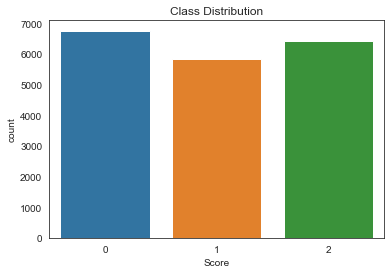

In [37]:
sns.set_style("white")
sns.countplot(df['Score']).set_title('Class Distribution')

plt.savefig('../images/class_distribution-before.png', bbox_inches = "tight", pad_inches=.5)

In [31]:
# Checking if there will be class imbalance
df.Score.value_counts()

2    128453
1     19508
0      6760
Name: Score, dtype: int64

In [32]:
# Creating separate dataframes depending on the classification
df_Score_0 = df[df.Score == 0]
df_Score_1 = df[df.Score == 1].sample(frac=0.3)
df_Score_2 = df[df.Score == 2].sample(frac=0.05)

In [33]:
# Concatenating th 
df = pd.concat([df_Score_2, df_Score_1, df_Score_0])
df.shape

(19035, 7)

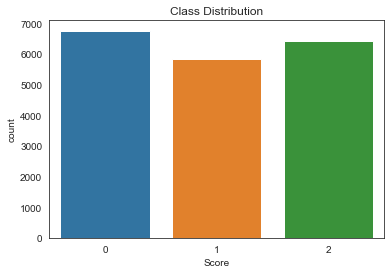

In [38]:
sns.countplot(df['Score']).set_title('Class Distribution')

plt.savefig('../images/class_distribution-after.png', bbox_inches = "tight", pad_inches=.5)

In [39]:
df.Score.value_counts()

0    6760
2    6423
1    5852
Name: Score, dtype: int64

In [40]:
# Saving csv with sentiment analysis
features = ['Hotel_Name', 'Negative_Review', 'Positive_Review', 'Reviewer_Score', 'Reviews_Clean', 'Score']
df = df[features]
df.to_csv("../csv/no_class_imbalance.csv")

# Spell Checker

## Tokenizer - Round 1

In [21]:
stop_words = stopwords.words('english')

In [22]:
# Instantiate CountVectorizer
cv = CountVectorizer(stop_words=stop_words)

# Fit and transform dataframe without data cleaning
df_cv = cv.fit_transform(df['Reviews_Clean'])
df_cv = pd.DataFrame(df_cv.toarray(), columns = cv.get_feature_names())
df_cv.index = df.index
df_cv.shape

(19035, 17383)

In [23]:
# Checking if function works
df['Spell_Checked'] = df['Reviews_Clean'].apply(lambda x: ''.join(TextBlob(x).correct()))

KeyboardInterrupt: 

In [ ]:
# Fit and transform dataframe without data cleaning
df_cv = cv.fit_transform(df['Spell_Checked'])
df_cv = pd.DataFrame(df_cv.toarray(), columns = cv.get_feature_names())
df_cv.index = df.index
df_cv.shape

In [ ]:
df.to_csv('csv/Hotel_Review_Spell_Checked.csv')

## Tokenizing and Processing Data

In [ ]:
df = pd.read_csv('../csv/Hotel_Review_Spell_Checked.csv')

In [ ]:
df.dropna(inplace=True)

In [ ]:
cleaned_review = df[['Spell_Checked', 'Score']]

In [ ]:
data = cleaned_review['Spell_Checked']
target = cleaned_review['Score']

In [ ]:
def process_review(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

In [ ]:
# Applying process_review to the data
processed_data = list(map(process_review, data))

In [ ]:
# Counting how many words there are
total_vocab = set()
for review in processed_data:
    total_vocab.update(review)
len(total_vocab)

## Lemmatization

In [ ]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [ ]:
X_lem = lemmatized_output
y_lem = target

In [ ]:
# pickle these for modeling
pickle_out = open('../pickled-files/X_lem.pkl','wb')
pickle.dump(X_lem, pickle_out)
pickle_out.close()